In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import string
import re
import os


import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint



In [4]:
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

In [147]:
train = pd.read_csv(r'C:\Users\rajat\Downloads\nlp-getting-started\train.csv')
test = pd.read_csv(r'C:\Users\rajat\Downloads\nlp-getting-started\test.csv')
target = train.target.values

In [6]:
print('Total rows and columnns in train are : {}, {}'.format(train.shape[0],train.shape[1]))
print('Total rows and columnns in test are : {}, {}'.format(test.shape[0],test.shape[1]))


Total rows and columnns in train are : 7613, 5
Total rows and columnns in test are : 3263, 4


In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [78]:
w = Tokenizer.tokenize(train.text.values[0])
w


TypeError: 'module' object is not callable

In [8]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

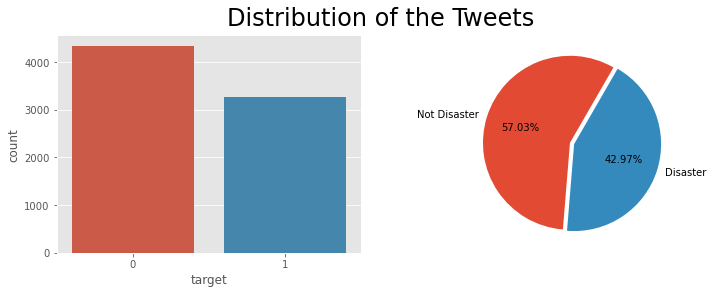

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=1,figsize=(12,4))
sns.countplot(train['target'], ax=axes[0])
axes[1].pie(train['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],autopct='%1.2f%%',
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

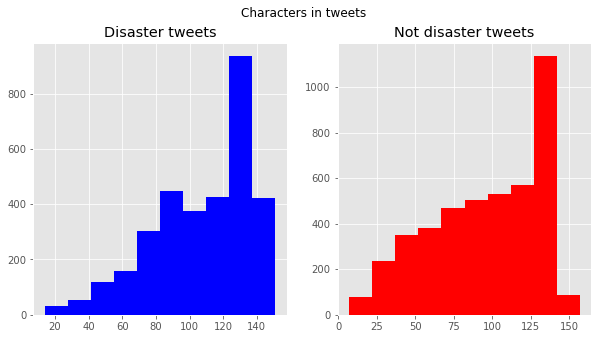

In [13]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

train_len = train[train['target']==1]['text'].str.len()

ax[0].hist(train_len,color='blue')
ax[0].set_title('Disaster tweets')

train_len = train[train['target']==0]['text'].str.len()

ax[1].hist(train_len,color='red')
ax[1].set_title('Not disaster tweets')

fig.suptitle('Characters in tweets')
plt.show()

Text(0.5, 1.0, 'not disaster')

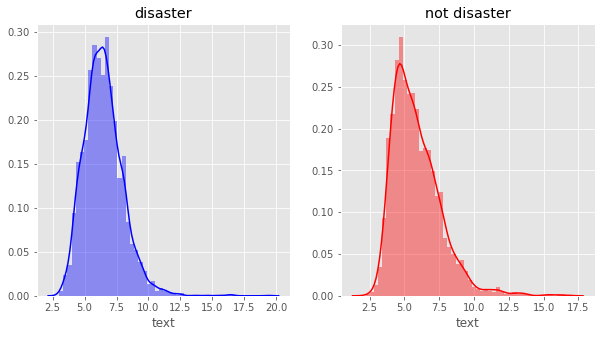

In [14]:
fig , ax = plt.subplots(1,2,figsize=(10,5))
words = train[train['target']==1]['text'].str.split().apply(lambda x: [len(w) for w in x])
sns.distplot(words.map(lambda x: np.mean(x)), ax = ax[0], color = 'blue')
ax[0].set_title('disaster')

words = train[train['target']==0]['text'].str.split().apply(lambda x: [len(w) for w in x])
sns.distplot(words.map(lambda x: np.mean(x)), ax = ax[1], color = 'red')
ax[1].set_title('not disaster')

In [29]:
def create_corpus(df, target):
    corpus=[]
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [16]:
np.array(stop)

array({"it's", "didn't", 'no', 'ma', 'aren', 'by', 'not', 'won', 'between', "isn't", 'haven', 'only', "couldn't", 'were', 'during', "should've", 'needn', 'you', 'am', 'should', 't', 'below', 'had', 'about', 'if', 'my', 'itself', 'doing', 'in', 'as', 'of', 'don', 'now', 'll', 'while', "needn't", 'and', "wouldn't", 'that', 'he', 'again', 'his', 'then', 'here', 'than', 'will', "hasn't", 'an', 'wouldn', 'this', 'or', 'very', 'been', 'hadn', "mustn't", "weren't", 'where', 'own', 'such', 'yourselves', 'weren', 'shouldn', "that'll", 'm', 'other', 'down', 'are', 'some', 'into', 'those', 'off', "she's", 'when', "hadn't", 'them', 'mightn', 'theirs', 'myself', 'its', 'is', 'we', "doesn't", 'they', 'd', 'most', 'at', 'yours', "you'll", 'she', 'isn', 'why', 'yourself', "shan't", 'same', 'have', 'hasn', 'nor', 'herself', "haven't", 'didn', "you're", 'what', 'can', 'few', 'couldn', "you've", "you'd", "won't", 'has', 'because', 'until', 'o', 'wasn', "wasn't", 'ourselves', 'after', 'the', 'above', 'eac

In [30]:
corpus = create_corpus(train, 0)

dic = defaultdict(int)
for w in corpus:
    if w in stop:
        dic[w]+=1
best = sorted(dic.items(), key = lambda x:x[1], reverse = True)[:20]
best

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442),
 ('on', 387),
 ('with', 349),
 ('that', 326),
 ('it', 290),
 ('be', 268),
 ('this', 225),
 ('by', 225),
 ('have', 219),
 ('at', 212),
 ('was', 205)]

Text(0.5, 1.0, 'Frequent words for no disaster')

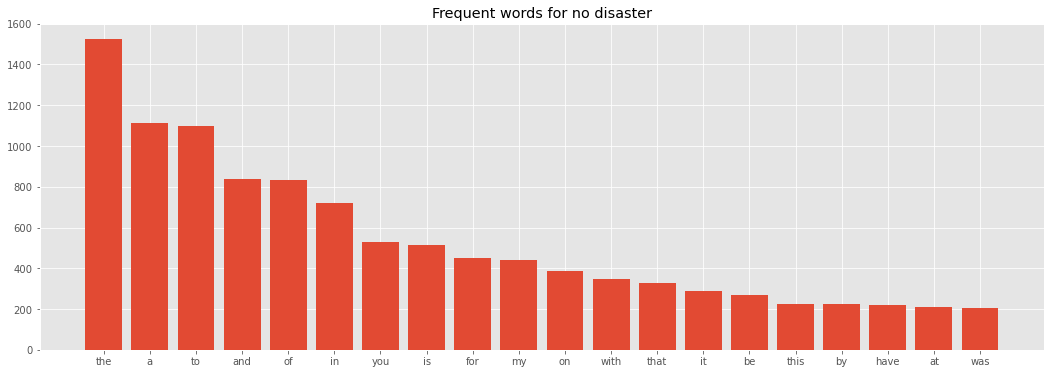

In [31]:
plt.figure(figsize = (18.0, 6.0))
x,y=zip(*best)
plt.bar(x,y)
plt.title('Frequent words for no disaster')

<BarContainer object of 20 artists>

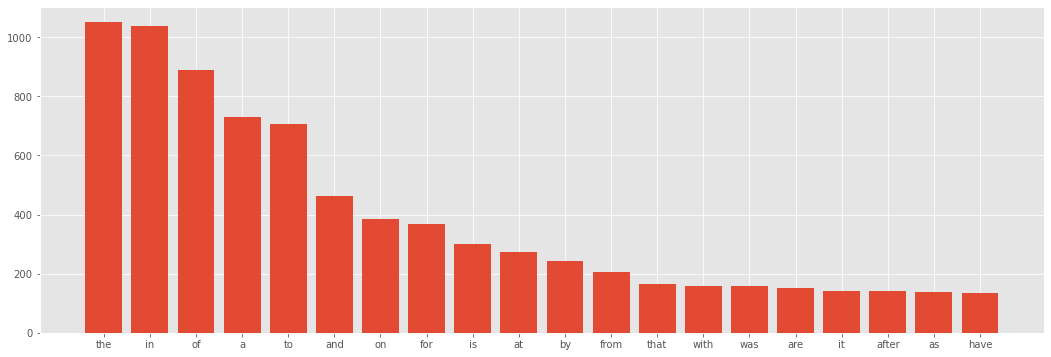

In [32]:
corpus = create_corpus(train, 1)

dic = defaultdict(int)
for w in corpus:
    if w in stop:
        dic[w]+=1
best = sorted(dic.items(), key = lambda x:x[1], reverse = True)[:20]
x,y = zip(*best)
plt.figure(figsize = (18.0, 6.0))
plt.bar(x,y)

<BarContainer object of 18 artists>

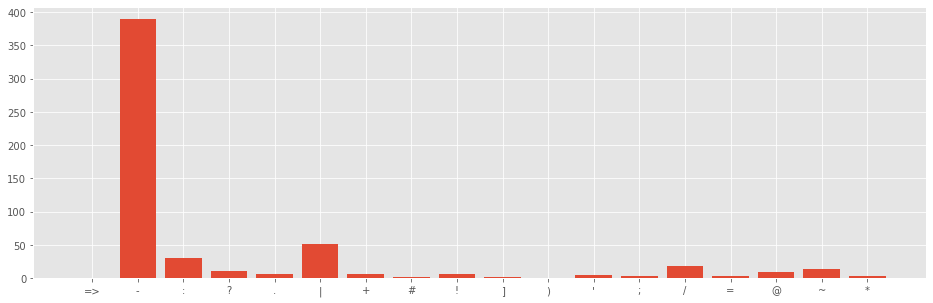

In [41]:
corpus = create_corpus(train, 1)

dic = defaultdict(int)
special = string.punctuation
for w in corpus:
    if w in special:
        dic[w]+=1

x,y = zip(*dic.items())
plt.figure(figsize = (16,5))
plt.bar(x,y)

<BarContainer object of 20 artists>

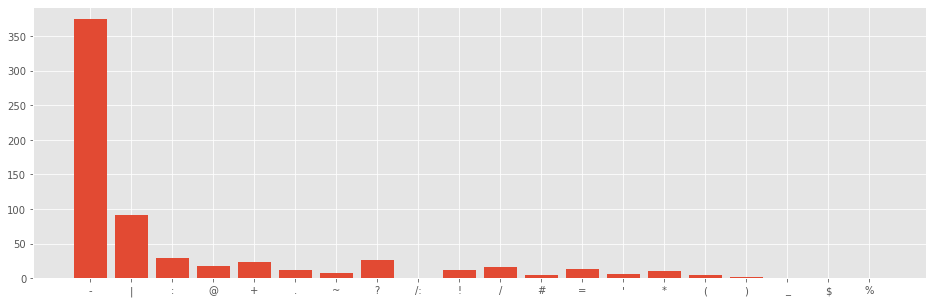

In [42]:
corpus = create_corpus(train, 0)

dic = defaultdict(int)
special = string.punctuation
for w in corpus:
    if w in special:
        dic[w]+=1

x,y = zip(*dic.items())
plt.figure(figsize = (16,5))
plt.bar(x,y)

In [46]:
df = pd.concat([train,test])
df.shape

(10876, 5)

In [50]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
df['text'] = df['text'].apply(lambda x: remove_url(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text'] = df['text'].apply(lambda x: remove_html(x))

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [55]:
corpus = create_corpus(df, 1)
corpus

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 'earthquake',
 'May',
 'ALLAH',
 'Forgive',
 'us',
 'all',
 'Forest',
 'fire',
 'near',
 'La',
 'Ronge',
 'Sask',
 'Canada',
 'All',
 'residents',
 'asked',
 'to',
 'shelter',
 'in',
 'place',
 'are',
 'being',
 'notified',
 'by',
 'officers',
 'No',
 'other',
 'evacuation',
 'or',
 'shelter',
 'in',
 'place',
 'orders',
 'are',
 'expected',
 '13000',
 'people',
 'receive',
 'wildfires',
 'evacuation',
 'orders',
 'in',
 'California',
 'Just',
 'got',
 'sent',
 'this',
 'photo',
 'from',
 'Ruby',
 'Alaska',
 'as',
 'smoke',
 'from',
 'wildfires',
 'pours',
 'into',
 'a',
 'school',
 'RockyFire',
 'Update',
 'California',
 'Hwy',
 '20',
 'closed',
 'in',
 'both',
 'directions',
 'due',
 'to',
 'Lake',
 'County',
 'fire',
 'CAfire',
 'wildfires',
 'flood',
 'disaster',
 'Heavy',
 'rain',
 'causes',
 'flash',
 'flooding',
 'of',
 'streets',
 'in',
 'Manitou',
 'Colorado',
 'Springs',
 'areas',
 'Im',
 'on',
 'top',
 'of',
 'the

In [56]:
corpus = create_corpus(df, 0)
corpus

['Whats',
 'up',
 'man',
 'I',
 'love',
 'fruits',
 'Summer',
 'is',
 'lovely',
 'My',
 'car',
 'is',
 'so',
 'fast',
 'What',
 'a',
 'goooooooaaaaaal',
 'this',
 'is',
 'ridiculous',
 'London',
 'is',
 'cool',
 'Love',
 'skiing',
 'What',
 'a',
 'wonderful',
 'day',
 'LOOOOOOL',
 'No',
 'wayI',
 'cant',
 'eat',
 'that',
 'shit',
 'Was',
 'in',
 'NYC',
 'last',
 'week',
 'Love',
 'my',
 'girlfriend',
 'Cooool',
 'Do',
 'you',
 'like',
 'pasta',
 'The',
 'end',
 'We',
 'always',
 'try',
 'to',
 'bring',
 'the',
 'heavy',
 'metal',
 'RT',
 'Crying',
 'out',
 'for',
 'more',
 'Set',
 'me',
 'ablaze',
 'On',
 'plus',
 'side',
 'LOOK',
 'AT',
 'THE',
 'SKY',
 'LAST',
 'NIGHT',
 'IT',
 'WAS',
 'ABLAZE',
 'PhDSquares',
 'mufc',
 'theyve',
 'built',
 'so',
 'much',
 'hype',
 'around',
 'new',
 'acquisitions',
 'but',
 'I',
 'doubt',
 'they',
 'will',
 'set',
 'the',
 'EPL',
 'ablaze',
 'this',
 'season',
 'Ablaze',
 'for',
 'you',
 'Lord',
 'D',
 'Check',
 'these',
 'out',
 'nsfw',
 'on',
 'th

In [58]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0


In [79]:
def vector(frame):
    vectoriser = CountVectorizer()
    emb = vectoriser.fit_transform(frame)
    return emb, vectoriser
corpus_l = df['text'].tolist()
labels = df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(corpus_l,labels, test_size = 0.2, 
                                                   random_state = 0)

X_train_vector, vectoriser = vector(X_train)
X_test_vector = vectoriser.transform(X_test)

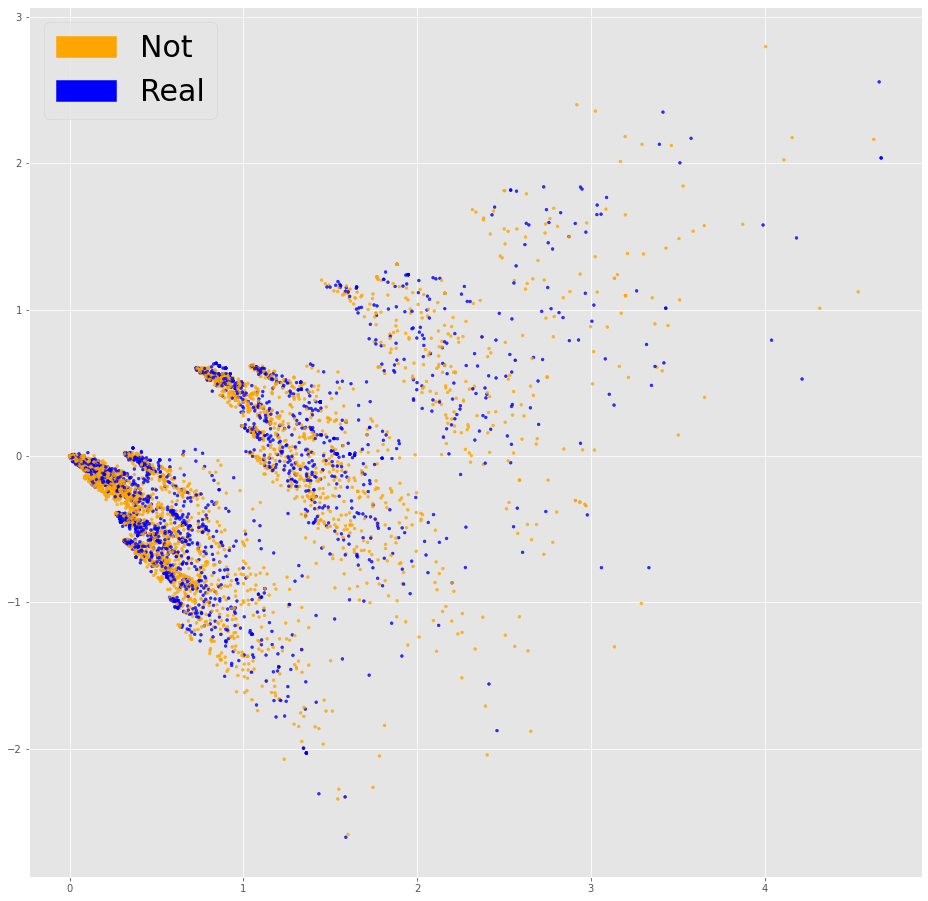

In [98]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = matplotlib.patches.Patch(color='orange', label='Not')
            blue_patch = matplotlib.patches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_vector, y_train)
plt.show()

In [99]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

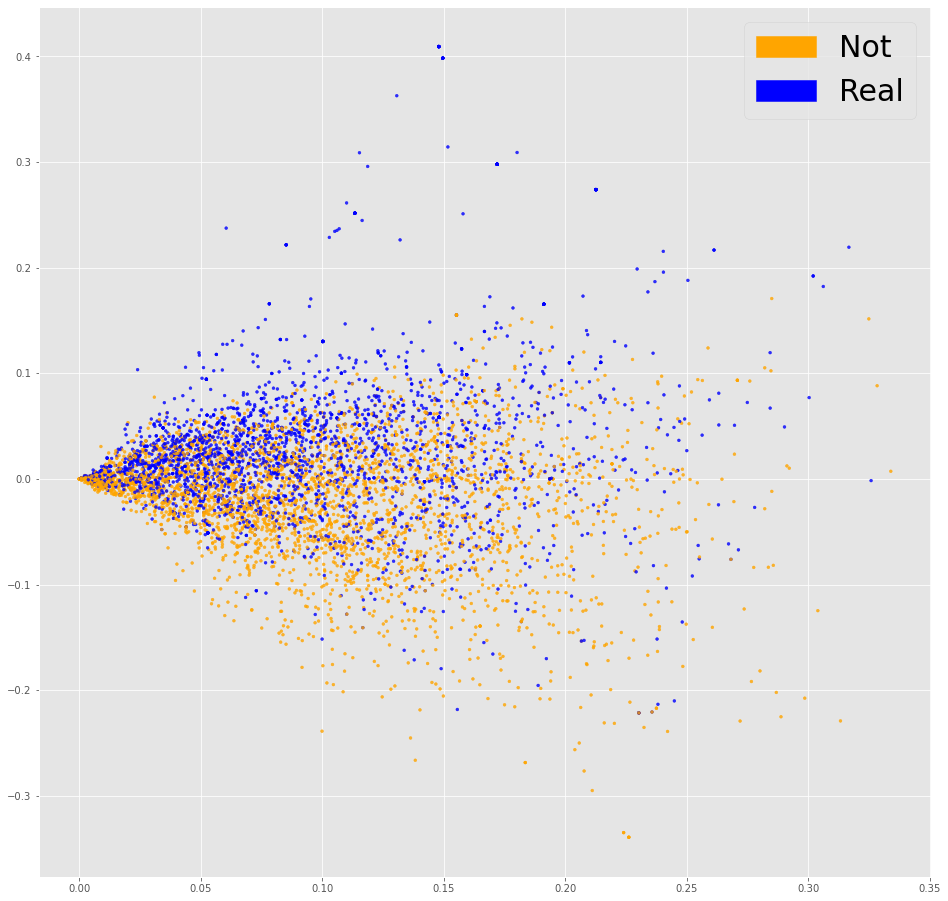

In [100]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [113]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [114]:
def create_corpus_new(df):
    corpus=[]
    for train in (df['text']):
        words=[word.lower() for word in word_tokenize(train)]
        corpus.append(words)
    return corpus   

In [115]:
corpus=create_corpus_new(df)

In [ ]:
corpus

In [132]:
embedding_dict={}
with open(r'C:\Users\rajat\Downloads\nlp-getting-started\glove.6B.100d.txt','r',encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float64')
        embedding_dict[word]=vectors
f.close()

In [133]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

text_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [134]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 22807


In [135]:
from tqdm import tqdm

In [136]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec

100%|████████████████████████████████████████████████████████████████████████| 22807/22807 [00:00<00:00, 200583.11it/s]


In [137]:
text_pad[0]

array([ 100, 5778,   20,    1,  814,    5,   18,  237,  136, 1902, 3703,
         68,   39,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [139]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [140]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2280800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 2,361,301
Trainable params: 80,501
Non-trainable params: 2,280,800
_________________________________________________________________


In [148]:
train=text_pad[:train.shape[0]]

In [149]:
train

array([[ 100, 5778,   20, ...,    0,    0,    0],
       [ 155,   41,  201, ...,    0,    0,    0],
       [  39, 1558, 1471, ...,    0,    0,    0],
       ...,
       [4188, 5708, 8166, ...,    0,    0,    0],
       [  76, 1208,   40, ...,    0,    0,    0],
       [   1,  208,   50, ...,    0,    0,    0]])

In [150]:
X_train,X_test,y_train,y_test=train_test_split(train,target,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 50)
Shape of Validation  (1523, 50)


In [151]:
history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=2)

Epoch 1/10
1523/1523 - 655s - loss: 0.5295 - accuracy: 0.7460 - val_loss: 0.4557 - val_accuracy: 0.8011
Epoch 2/10
1523/1523 - 360s - loss: 0.4825 - accuracy: 0.7829 - val_loss: 0.4627 - val_accuracy: 0.7984
Epoch 3/10
1523/1523 - 359s - loss: 0.4651 - accuracy: 0.7939 - val_loss: 0.4578 - val_accuracy: 0.7951
Epoch 4/10
1523/1523 - 359s - loss: 0.4593 - accuracy: 0.7928 - val_loss: 0.4490 - val_accuracy: 0.7965
Epoch 5/10
1523/1523 - 361s - loss: 0.4517 - accuracy: 0.7982 - val_loss: 0.4395 - val_accuracy: 0.8076
Epoch 6/10
1523/1523 - 358s - loss: 0.4522 - accuracy: 0.7987 - val_loss: 0.4758 - val_accuracy: 0.7761
Epoch 7/10
1523/1523 - 356s - loss: 0.4497 - accuracy: 0.7987 - val_loss: 0.4433 - val_accuracy: 0.8096
Epoch 8/10
1523/1523 - 357s - loss: 0.4393 - accuracy: 0.8085 - val_loss: 0.4523 - val_accuracy: 0.8083
Epoch 9/10
1523/1523 - 352s - loss: 0.4378 - accuracy: 0.8090 - val_loss: 0.4327 - val_accuracy: 0.8175
Epoch 10/10
1523/1523 - 359s - loss: 0.4269 - accuracy: 0.8120 -

In [216]:
test = pd.read_csv(r'C:\Users\rajat\Downloads\nlp-getting-started\test.csv')

In [217]:
test=text_pad[:test.shape[0]]

In [218]:
test.shape

(3263, 50)

In [219]:
test_pred_GloVe = model.predict(test)

In [220]:
test_pred_GloVe.shape

(3263, 1)

In [221]:
test_pred_GloVe = test_pred_GloVe.round().astype('int')

In [227]:
sample=pd.read_csv(r'C:\Users\rajat\Downloads\nlp-getting-started\test.csv')
idd = sample['id'].values
idd

array([    0,     2,     3, ..., 10868, 10874, 10875], dtype=int64)

In [228]:
sub=pd.DataFrame({'id':idd,'target':test_pred_GloVe.reshape(-1)})

In [229]:
sub.to_csv('submission.csv',index=False)